In [25]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import os
import matplotlib.pyplot as plt
import cortex
from os.path import join
from collections import defaultdict
import numpy as np
import joblib
from tqdm import tqdm
import sys
import matplotlib.gridspec as gridspec

from copy import deepcopy
sys.path.append('../notebooks')
from neuro.config import repo_dir, PROCESSED_DIR
from neuro import viz, analyze_helper
from neuro.features.questions.gpt4 import QS_35_STABLE
from neurosynth import term_dict, term_dict_rev, get_neurosynth_flatmaps
neurosynth_compare = __import__('04_neurosynth_compare')
import viz
import neurosynth
from cortex import mni
import os
from statsmodels.stats.multitest import multipletests
from neuro.config import repo_dir, PROCESSED_DIR, setup_freesurfer
import seaborn as sns

gct = joblib.load(join('corrs_df', 'gemv.pkl'))
intersubject = joblib.load(join('corrs_df', 'intersubject.pkl'))
neurosynth = joblib.load(join('corrs_df', 'neurosynth.pkl')).pivot_table(
    index='questions', columns='subject', values='corrs_0.1')

gct.index = gct.questions
# remove asterisks
gct.index = [analyze_helper.abbrev_question(q.replace('*', '').strip()) for q in gct.index]
gct = gct.drop(columns=['questions'])
intersubject.index = [analyze_helper.abbrev_question(
    q) for q in intersubject.index]
intersubject['AVG_intersubj'] = intersubject.mean(axis=1)
neurosynth.index = [analyze_helper.abbrev_question(
    q[0]) for q in neurosynth.index]
neurosynth['AVG_neurosynth'] = neurosynth.mean(axis=1)

gct = gct[gct.columns[::-1]]
intersubject = intersubject[intersubject.columns[::-1]]
neurosynth = neurosynth[neurosynth.columns[::-1]]

# merge on
df = pd.merge(neurosynth, gct, left_index=True, right_index=True,
              how='outer')
df = pd.merge(df, intersubject, left_index=True, right_index=True,
              how='outer')

# drop all non-numeric questions
df = df.dropna(axis=0, how='all')

df = df.sort_values(by='corrs_1')

question_corrs = pd.read_pickle(
    'corrs_df/single_question_corrs.pkl').set_index('question')['corrs_test_mean'].to_dict()
question_corrs = {analyze_helper.abbrev_question(k): v for k, v in question_corrs.items()}
df['Prediction performance'] = df.index.map(question_corrs)

# add avg row
df.loc['AVG'] = df.mean(axis=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


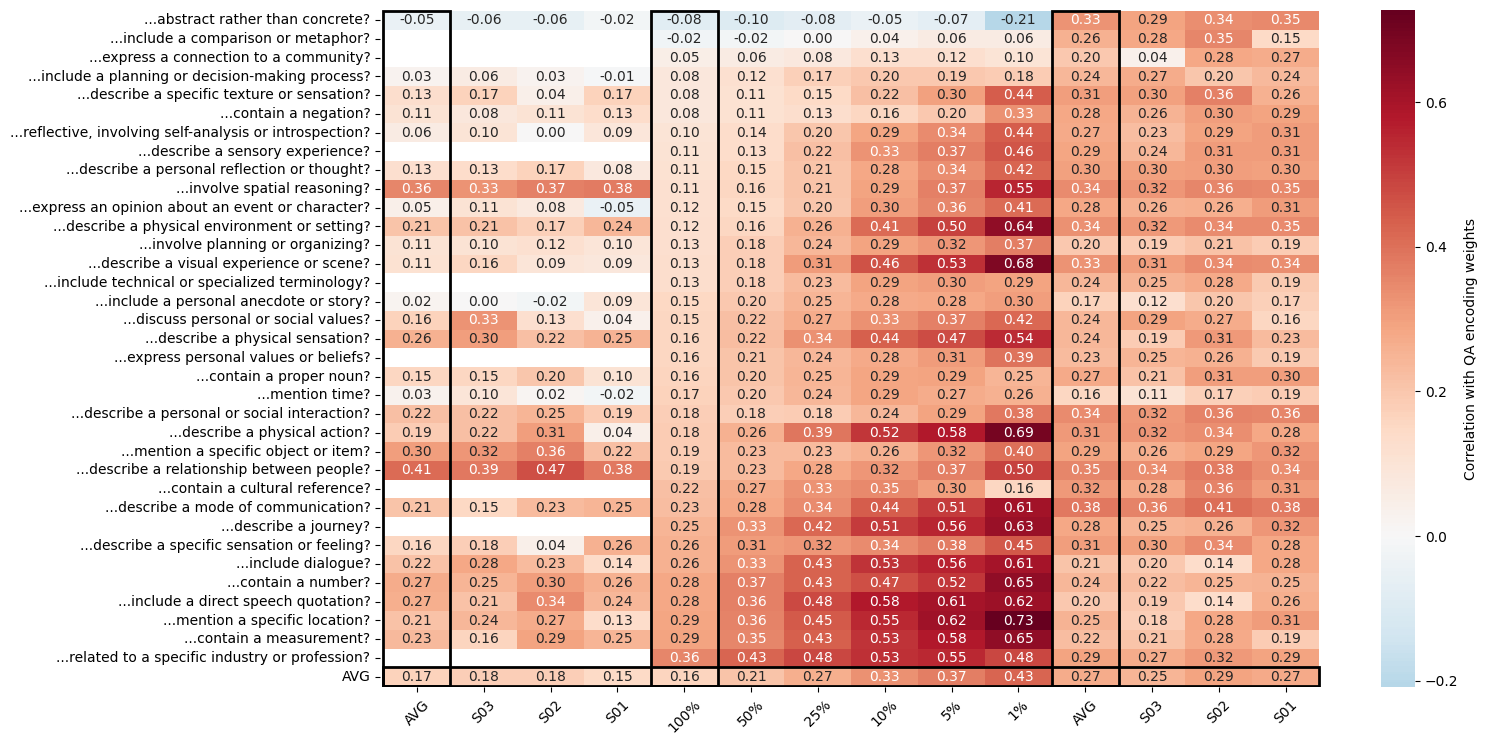

In [65]:
df_ = df.drop(columns='Prediction performance')
plt.figure(figsize=(19 * 0.8, 11 * 0.8))
sns.heatmap(df_, cmap='RdBu_r', center=0, annot=True, fmt='.2f',
            cbar_kws={'label': 'Correlation with QA encoding weights'})

# add outline for column corrs_1
for i in [0, 4, 10]:
    plt.gca().add_patch(plt.Rectangle((i, 0), 1, len(df_),
                                      fill=False, edgecolor='black', lw=2))
# add outline for bottom row
plt.gca().add_patch(plt.Rectangle((0, len(df_) - 1), len(df_.columns), 1,
                                  fill=False, edgecolor='black', lw=2))


# reset labels
xlabs = [
    'AVG', 'S03', 'S02', 'S01',
    '100%', '50%', '25%', '10%', '5%', '1%',
    'AVG', 'S03', 'S02', 'S01',
]

plt.xticks(ticks=0.5 + np.arange(len(df_.columns)), labels=xlabs, rotation=45)
# increase ylim by 1
off = 0.05
plt.ylim(len(df_) + off * 1.5, -off)
plt.xlim(-off, len(df_.columns) + off)

plt.savefig('corrs_df/heatmap.png', dpi=500, bbox_inches='tight')

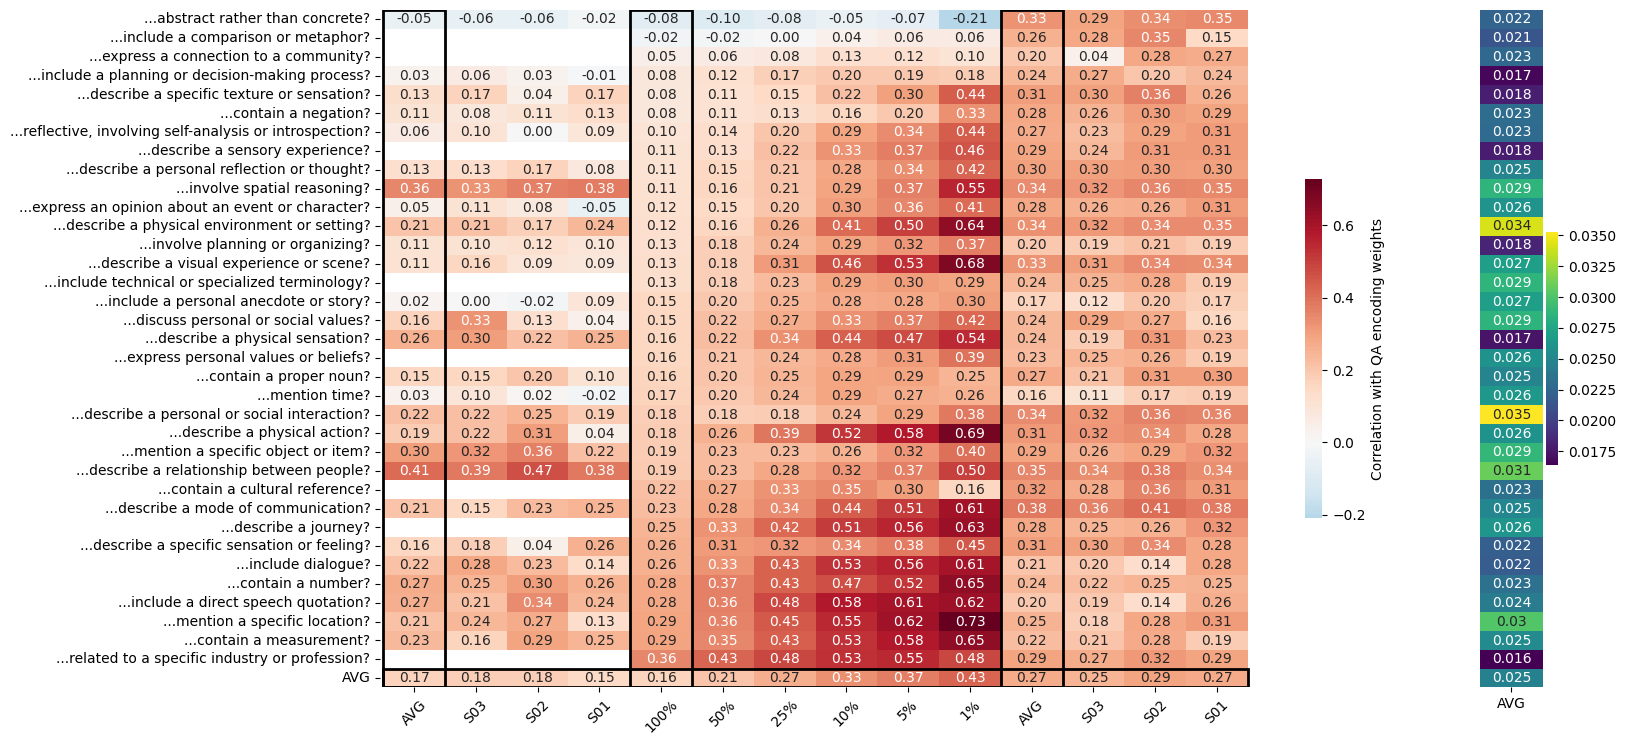

In [63]:
plt.figure(figsize=(19 * 0.8, 11 * 0.8))
df_ = df.drop(columns='Prediction performance')
data_left = df.drop(columns='Prediction performance').values
data_right = df['Prediction performance'].values.reshape(-1, 1)
gs = gridspec.GridSpec(1, 2, width_ratios=[data_left.shape[1], 1], wspace=0.02)

ax_left = plt.subplot(gs[0])

sns.heatmap(data_left, cmap='RdBu_r', center=0, annot=True, fmt='.2f',
            cbar_kws={'label': 'Correlation with QA encoding weights', 'shrink': 0.5}, ax=ax_left, )

# add outline for column corrs_1
for i in [0, 4, 10]:
    plt.gca().add_patch(plt.Rectangle((i, 0), 1, len(df_),
                                      fill=False, edgecolor='black', lw=2))
# add outline for bottom row
plt.gca().add_patch(plt.Rectangle((0, len(df_) - 1), len(df_.columns), 1,
                                  fill=False, edgecolor='black', lw=2))

# reset labels
xlabs = [
    'AVG', 'S03', 'S02', 'S01',
    '100%', '50%', '25%', '10%', '5%', '1%',
    'AVG', 'S03', 'S02', 'S01',
    # 'Prediction performance',
]

plt.xticks(ticks=0.5 + np.arange(len(df_.columns)), labels=xlabs, rotation=45)
plt.yticks(ticks=0.5 + np.arange(len(df_.index)), labels=df_.index, rotation=0)
# increase ylim by 1
off = 0.05
# plt.ylim(len(df_) + off * 3, -off * 3)
ax_left.set_ylim(len(df_) + off * 3, -off * 3)
ax_left.set_xlim(-off, len(df_.columns) + off)

ax_right = plt.subplot(gs[1], sharey=ax_left)
sns.heatmap(data_right, ax=ax_right, cbar=True,
            cmap='viridis', yticklabels=df_.index, annot=True, xticklabels=['AVG'])
# cbar_kws={'shrink': 0.5}) #yticklabels=False)#xticklabels=False, yticklabels=False)
ax_right.yaxis.set_visible(False)

plt.savefig('corrs_df/heatmap_with_pred.png', dpi=500, bbox_inches='tight')